# How to analyze Chip-Seq data based on gene orientation?

In [1]:
import numpy as np

# Path indication to the GRATIOSA package
import sys
sys.path.insert(0, '/home/usr/packages/GRATIOSA/') 

# Loading the modules for data loading
from GRATIOSA import Genome, Chipseq

# Loading the statistical analysis and graphic modules
from GRATIOSA import stat_analysis, plot_stat_analysis

# 1 - Data importation and pre-processing

### Genomic annotation loading
The orientation of each position is determined based on the strands where the two neighboring genes are located
+ divergent: if left neighbor on - strand and right neighbor on + strand,
+ convergent: if left neighbor on + strand and right neighbor on - strand,
+ tandem: if left and right neighbors on same strand
+ isolated: if the distance between neighbors is higher than the maximal distance given as argument

In [2]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_annotation()
g.load_pos_orientation()

Trying to load annotation from: /home/maiwenn/these/data/ecoli_W3110_Mu/annotation/sequence.gff3
Annotation loaded


### Chip-Seq signals loading and pre-processing

In [3]:
# Initialization of the Chipseq object
ch = Chipseq.Chipseq("ecoli_W3110_Mu")

# Selection of replicates for each signal type
cond = {"Topo": ["Sutormin_shift_TopoI_R1", "Sutormin_shift_TopoI_R2", "Sutormin_shift_TopoI_R3"],
        "rifTopo": ["Sutormin_TopoI_Rif_R1","Sutormin_TopoI_Rif_R3"],
        "Gyr": ["Sutormin_shift_Gyrase_R1", "Sutormin_shift_Gyrase_R2"],
        "rifGyr":  ["Sutormin_CFX_Rif_Gyrase_R2", "Sutormin_CFX_Rif_Gyrase_R3"]
       }  

# Calculates the average signal between replicates for each genomic position
for styp in cond.keys():
    ch.load_signals_average(list_cond=cond[styp],
                            average_name=styp)

loading the file obtained with the following parameters:

Name: Topo

 Replicates: ['Sutormin_shift_TopoI_R1', 'Sutormin_shift_TopoI_R2', 'Sutormin_shift_TopoI_R3']

 Data treatment: No treatment

 Size (window or bin, in b): NA

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: rifTopo

 Replicates: ['Sutormin_TopoI_Rif_R1', 'Sutormin_TopoI_Rif_R3']

 Data treatment: No treatment

 Size (window or bin, in b): NA

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Gyr

 Replicates: ['Sutormin_shift_Gyrase_R1', 'Sutormin_shift_Gyrase_R2']

 Data treatment: No treatment

 Size (window or bin, in b): NA

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: rifGyr

 Replicates: ['Sutormin_CFX_Rif_Gyrase_R2', 'Sutormin_CFX_Rif_Gyrase_R3']

 Data treatment: No treatment

 Size (window or bin, in b): NA

Ple

# 2 - Statistical analysis of intergenic signal 

### Adding a function specific to this study.

This function divides a list of positions into bins and calculates the average signal for each bin. 
The binning is done in such a way that:
+ each bin contains only adjacent positions
+ each bin has a size greater than min_bs
+ each bin has a size as close as possible to bs"

In [4]:
def binning(bs, min_bs, signal, positions) :
    min_positions = [positions[0]]
    max_positions = []

    # Step 1: Find adjacent positions to create windows
    for p,position in enumerate(positions):
        if p != 0 :
            if position > positions[p-1] + 1: 
                min_positions.append(position)
                max_positions.append(positions[p-1])
    max_positions.append(positions[-1])

    # Step 2: Divide the windows into bins and calculate the mean signal in each bin
    new_signal = []
    for min_position, max_position in zip(min_positions, max_positions):
        # Determine the bin edges to respect the chosen binsize
        num_bins = (max_position - min_position) // bs + 1
        bin_edges = np.linspace(min_position, max_position, num_bins + 1)

        # Calculate the mean signal for each bin and store it if it meets the minimum bin size requirement
        for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
            bin_signal = signal[int(bin_start):int(bin_end)]
            # Check if the bin size meets the minimum requirement (min_bs)
            if len(bin_signal) >= min_bs:
                new_signal.append(np.nanmean(bin_signal))

    return new_signal

### Statistical comparison of signal density in intergenic regions based on the orientation of surrounding genes

Results saved in /home/maiwenn/these/resdir/student_test/Topo_bin100b_orientation


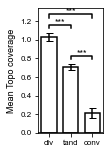

Results saved in /home/maiwenn/these/resdir/student_test/rifTopo_bin100b_orientation


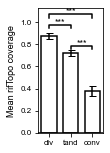

Results saved in /home/maiwenn/these/resdir/student_test/Gyr_bin100b_orientation


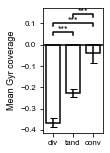

Results saved in /home/maiwenn/these/resdir/student_test/rifGyr_bin100b_orientation


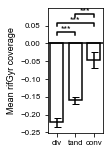

In [5]:
min_bs = 50 # in b
binsize = 100 # in b
binned_signals = {}

for styp in ch.signals_average.keys() :
    binned_signals[styp] = {}
    
    # compute the signal density per bin for each orientation
    for ori in ['divergent','tandem', 'convergent'] : 
        binned_signals[styp][ori] = binning(binsize,min_bs,ch.signals_average[styp],g.pos_orientation["intergenic"][ori])
    
    # performs the statistical tests and plots the results
    plot_stat_analysis.plot_student_test(binned_signals[styp],
                                         output_file=f"{styp}_bin{binsize}b_orientation",
                                         ylabel=f"Mean {styp} coverage",
                                         xticks_labels = ["div","tand","conv"]
                                        )

### Analysis of the difference between the signals with and without rifampicin for each orientation

Results saved in /home/maiwenn/these/resdir/student_test/Topo_bin100b_orientation


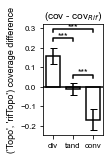

Results saved in /home/maiwenn/these/resdir/student_test/Gyr_bin100b_orientation


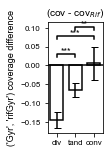

In [6]:
signals_rif_no_rif = {'TopoI' : {}, 'Gyrase' : {}}

for styp in [("Topo","rifTopo"),("Gyr","rifGyr")] :
    diff_sign = {}
    
    for ori in ['divergent','tandem', 'convergent'] : 
        diff_sign[ori] = binned_signals[styp[0]][ori] - np.mean(binned_signals[styp[1]][ori])
   
    plot_stat_analysis.plot_student_test(diff_sign,
                                         output_file=f"{styp[0]}_bin{binsize}b_orientation",
                                         title = "(cov - cov$_{Rif}}$)",
                                         ylabel=f"{styp} coverage difference",
                                         xticks_labels = ["div","tand","conv"]
                                        )